# Exercise 1 - On-Policy Reinforcement Learning with Parametric Policy

In [2]:
import numpy as np
import lqg1d
import matplotlib.pyplot as plt
import utils
from tqdm import tqdm

from pylab import rcParams
rcParams['figure.figsize'] = 5,5

## Question 1 - REINFORCE with Gaussian Policy Model

In [23]:
#####################################################
# Define the environment and the policy
#####################################################

env = lqg1d.LQG1D(initial_state_type='random')

class Gaussian_Policy():
    #implements the gaussian policy
    
    def __init__(self, sigma=0.4):
        self.sigma = sigma
        self.theta = -0.4
        
    def update_theta(self, delta_theta):
        self.theta += delta_theta
        
    def gradient_theta(self,state,action):
        #computes the gradient of log(pi(action|state)) with respect to theta
        grad = (action-self.theta*state)*state
        return grad/(self.sigma*self.sigma)
        
    def draw_action(self,state):
        mu = self.theta * state
        action = np.random.normal(loc = mu, scale = self.sigma)
        return np.clip(action, -40, 40)
        
#####################################################
# Experiments parameters
#####################################################

# Set the discount factor for the problem
discount = 0.9

# We will collect N trajectories per iteration
N = 1000 #100
# Each trajectory will have at most T time steps
T = int(-np.log(discount/1000)/(1-discount)) #reward bounded by 1/2*(40*40+20*20)=1000
print("maximal length of a trajectory : ",T)
# Number of policy parameters updates
n_itr = 100
# Learning rate for the gradient update
learning_rate = 10**(-4)

optimal_theta = env.computeOptimalK(discount)
print("optimal theta : "+str(optimal_theta))

maximal length of a trajectory :  70
optimal theta : [[-0.58840335]]


In [24]:
#####################################################
# define the update rule (stepper)

class ConstantStep(object):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt
    
class AnnealingStep(object):
    def __init__(self, learning_rate, T_end):
        self.learning_rate = learning_rate
        self.T_end = T_end

    def update(self, gt, t):
        return self.learning_rate * (1 - t/self.T_end) * gt
    
#None # e.g., constant, adam or anything you want    
#stepper = ConstantStep(learning_rate) 
stepper =  AnnealingStep(learning_rate,n_itr)

In [131]:
# fill the following part of the code with
#  - REINFORCE estimate i.e. gradient estimate
#  - update of policy parameters using the steppers
#  - average performance per iteration
#  - distance between optimal mean parameter and the one at it k

def REINFORCE(nb_simul):
    #implements the REINFORCE algorithm with Gaussian policy
    #average the performances on nb_simul simulations of the algorithm
    #returns : mean_parameters, std_parameters, avg_return, std_return
    #ie. the mean and the standard deviation of the estimated parameters
    #at each iteration
    #and the mean and the standard deviation of the policy performances
    #J (expected discounted reward) at each iteration 
    
    parameters = np.zeros((nb_simul,n_itr)) #theta at each iteration for each simulation 
    returns = np.zeros((nb_simul,n_itr)) #J at each iteration for each simulation 

    for cpt_simul in tqdm(range(nb_simul)):
                
        policy = Gaussian_Policy(sigma=0.4) #init Gaussian policy

        for cpt_iter in range(n_itr):

            #1. collect trajectories following Gaussian policy
            
            paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)

            #2. estimate gradient of J with respect to theta
            
            grad = 0 #gradient estimate
            total_return = 0 #J estimate 

            for p in range(N):

                path = paths[p]
                
                #discounted rewards at each t 
                rewards = [(discount**t) * rew 
                           for (t,rew) in enumerate(path["rewards"].flatten())]

                #for each t, gradient of pi(a_t|s_t) with respect to theta 
                gradients = policy.gradient_theta(path["states"].flatten(),
                                                  path["actions"].flatten())

                grad += np.sum(gradients)*np.sum(rewards)
                total_return += np.sum(rewards)

            grad /= N
            total_return /= N
            
            # 3. update theta

            #delta_theta = stepper.update(grad)
            delta_theta = stepper.update(grad,cpt_iter)
            policy.update_theta(delta_theta)

            # 4. save theta estimate and average return at this iteration

            parameters[cpt_simul,cpt_iter] = policy.theta
            returns[cpt_simul,cpt_iter] = total_return
        
    mean_parameters = np.mean(parameters,axis=0)
    avg_return = np.mean(returns,axis=0)
    
    std_parameters = np.std(parameters,axis=0)
    std_return = np.std(returns,axis=0)
            
    return mean_parameters, std_parameters, avg_return, std_return

In [ ]:
nb_simul = 5
mean_parameters, std_parameters, avg_return, std_return =  REINFORCE(nb_simul=nb_simul)

optimal theta : -0.5884033489985556


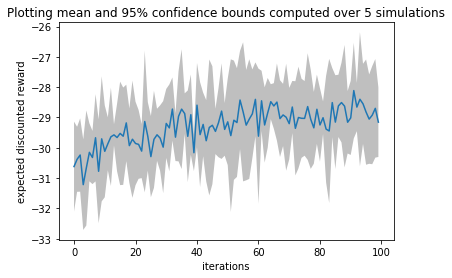

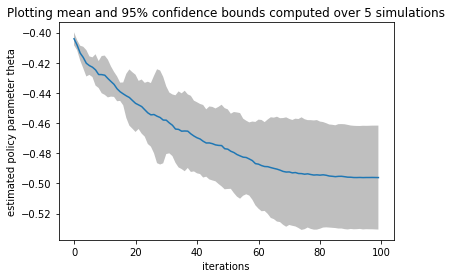

In [6]:
optimal_theta = env.computeOptimalK(discount)[0,0]
print("optimal theta : "+str(optimal_theta))

# plot the average return obtained by simulating the policy
# at each iteration of the algorithm (this is a rough estimate
# of the performance)
fig,ax = plt.subplots(1)
plt.plot(avg_return)
ax.fill_between(list(range(len(avg_return))), 
                avg_return-2*std_return, avg_return+2*std_return, facecolor='grey', alpha=0.5)
ax.set_xlabel('iterations')
ax.set_ylabel('expected discounted reward')
ax.set_title('Plotting mean and 95% confidence bounds computed over '
             +str(nb_simul)+ ' simulations')
plt.show()

# plot the mean parameter at iteration k
fig,ax = plt.subplots(1)
plt.plot(mean_parameters)
ax.set_xlabel('iterations')
ax.set_ylabel('estimated policy parameter theta')
ax.set_title('Plotting mean and 95% confidence bounds computed over '
             +str(nb_simul)+ ' simulations')
ax.fill_between(list(range(len(mean_parameters))), 
                mean_parameters-2*std_parameters, mean_parameters+2*std_parameters, facecolor='grey', alpha=0.5)
plt.show()

**Experimental setup**

- Preliminary note : It seems there was small inconsistencies between the assignment and the code according to the space of states/actions. I chose not to change the code and keep [-20,20] for the state space and [-40,-40] for the action space (it seemed to me more natural for such a regulation problem). 


- On the plots above are shown the estimations throughout the iterations of the policy parameter theta, as well as the expected discounted reward. These estimations are averages over 5 simulations (initializing theta to -0.4 for each), and we also plot the bounds of the 95% confidence interval (minus/plus 2 times the standard deviation across the runs).


- I finally used an linear annealing scheme for the learning rate, starting at $10^{-4}$ and annealing at $N_{iter}$=101, and collected $N=1000$ trajectories per iteration for the Monte-Carlo estimation of the gradient. I kept $\sigma = 0.4$, and chose, following TP1 reference, the horizon $T=-log(\gamma/R_{max})/(1-\gamma)$ (infine-horizon discounted problem). Here $\gamma$ = 0.9 and $R_{max}$ = 1000 (reward equal to minus the average of the squared norm of $r_t$ and the squared norm of $a_t$, hence bounded by 0.5*(20^2+40^2) = 1000), which led to $T=70$.

**Results**

- We observe that the mean estimation of theta decreases throughout the iterations and get closer to the optimal value (around $-0.58$), but we would certainly need a larger $N_{iter}$ keeping such annealing scheme, or a better stepsize policy to observe the convergence towards the optimal value. We can also observe a convergence (yet very shaky) of the mean expected discounted reward towards $-29$ but choosing better hyperparameters should certainly improve the convergence again.



- We also observe the very high variance of the estimation of theta and of the reward : further increasing N (the number of trajectories needed for the MC estimation of the gradient at each iteration) should probably reduce it, but with such a value it already took a while on my computer...

**Impact of the learning rate and of N**

- In the case of standard update rule, the larger the learning rate, the faster the convergence, but if the learning rate is too large, it will diverge. Hence, one should choose the largest learning rate such that the estimation converges : i found $2. 10^{-5}$ as the best value for standard update rule.


- Finally, the larger N (number of trajectories per iteration), the less variance around the estimation of theta and of the reward. Indeed the larger N, the more accurate is the MC estimation of the gradient of the expected discounted reward with respect to theta the policy parameter.

## Question 2 - REINFORCE with Exploration Bonus, with Gaussian Policy Model

In [41]:
#discretization to count the number of visits of an (state,action) pair

nb_discrete_actions=20
nb_discrete_states=20

discrete_actions = np.linspace(-40, 40, nb_discrete_actions)
discrete_states = np.linspace(-20, 20, nb_discrete_states)

beta = 1.

In [42]:
def find_closest_discrete_elements(discrete_dict,values_to_look_for):
    #returns index of closest discrete elements of values_to_look_for (array) 
    #within discrete_dict (sorted array)
    
    # np.searchsorted(l,l2) returns the indices of insertions of elements
    # of l2 in sorted list l
    idx_closest = np.searchsorted(discrete_dict,values_to_look_for,side="left") 
    
    # hence, for discretization, we just need to compare between 
    # np.searchsorted(l,l2) and np.searchsorted(l,l2)-1
    # for output indices in [1,len(discrete_dict)-1]
    for idx in range(values_to_look_for.shape[0]):
        v = values_to_look_for[idx]
        tmp = idx_closest[idx]
        if tmp > 0:
            if tmp == discrete_dict.shape[0]:
                idx_closest[idx] = tmp - 1
            else:
                if np.abs(v-discrete_dict[tmp-1])<np.abs(v-discrete_dict[tmp]):
                    idx_closest[idx] = tmp - 1
                    
    return idx_closest    

In [43]:
#stepper = ConstantStep(learning_rate) 
stepper =  AnnealingStep(learning_rate,n_itr) 

# fill the following part of the code with
#  - REINFORCE estimate i.e. gradient estimate
#  - update of policy parameters using the steppers
#  - average performance per iteration
#  - distance between optimal mean parameter and the one at it k

def REINFORCE_with_bonus(nb_simul):
    #implements the REINFORCE algorithm with exploration bonus
    #average the performances on nb_simul simulations of the algorithm
    #returns : mean_parameters, std_parameters, avg_return, std_return
    #ie. the mean and the standard deviation of the estimated parameters
    #at each iteration
    #and the mean and the standard deviation of the policy performances
    #J (expected discounted reward) at each iteration 
    
    parameters = np.zeros((nb_simul,n_itr)) #theta at each iteration for each simulation 
    returns = np.zeros((nb_simul,n_itr)) #J at each iteration for each simulation 

    for cpt_simul in tqdm(range(nb_simul)):
                
        policy = Gaussian_Policy(sigma=0.4) #init Gaussian policy
        nb_visits = np.zeros((nb_discrete_states, nb_discrete_actions))
        
        for cpt_iter in range(n_itr):
        
            #1. collect trajectories following Gaussian policy
            
            paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)
            
            #2. estimate gradient of J with respect to theta
            
            grad = 0 #gradient estimate
            total_return = 0 #J estimate
            
            # nb of visits of each pair (state,action) at this iteration
            new_nb_visits = np.zeros((nb_discrete_states, nb_discrete_actions))

            for p in range(N):

                path = paths[p]
                
                # rewards at each t 
                rewards = [(discount**t) * rew 
                           for (t,rew) in enumerate(path["rewards"].flatten())]
                
                # compute exploration bonus at each t and update new_nb_visits
                bonus = np.zeros(T)
                
                discrete_states_visited = find_closest_discrete_elements(discrete_states,
                                                                         path["states"].flatten())
                discrete_actions_visited = find_closest_discrete_elements(discrete_actions,
                                                                          path["actions"].flatten())
                for t in range(T):
                    s = discrete_states_visited[t]
                    a = discrete_actions_visited[t]
                    bonus[t] = beta*np.sqrt(1/(nb_visits[s,a]+1))
                    new_nb_visits[s,a] += 1
                                                                        
                # discounted rewards + bonus at each t
                rewards_with_bonus = [(discount**t) * (rewards[t]+bonus[t]) 
                                      for t in range(len(rewards))]
                                                    
                #for each t, gradient of pi(a_t|s_t) with respect to theta 
                gradients = policy.gradient_theta(path["states"].flatten(),
                                                  path["actions"].flatten())

                #we count bonus only for the policy improvement, not for its assessment !
                grad += np.sum(gradients)*np.sum(rewards_with_bonus)
                total_return += np.sum(rewards)

            grad /= N
            total_return /= N
            new_nb_visits /= N
            
            # 3. update theta and nb_visits

            delta_theta = stepper.update(grad, cpt_iter)
            policy.update_theta(delta_theta)
            
            nb_visits = nb_visits + new_nb_visits 

            # 4. save theta estimate and average return at this iteration

            parameters[cpt_simul,cpt_iter] = policy.theta
            returns[cpt_simul,cpt_iter] = total_return
            
        
    mean_parameters = np.mean(parameters,axis=0)
    avg_return = np.mean(returns,axis=0)
    
    std_parameters = np.std(parameters,axis=0)
    std_return = np.std(returns,axis=0)
            
    return mean_parameters, std_parameters, avg_return, std_return

In [ ]:
nb_simul = 5
mean_parameters, std_parameters, avg_return, std_return =  REINFORCE_with_bonus(nb_simul=nb_simul)

optimal theta : -0.5884033489985556


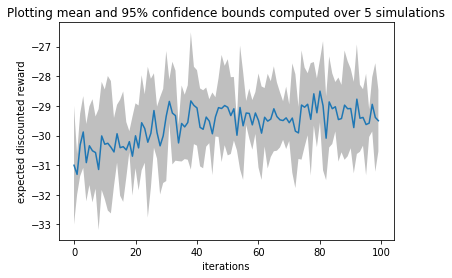

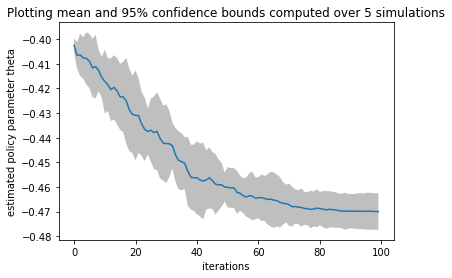

In [45]:
optimal_theta = env.computeOptimalK(discount)[0,0]
print("optimal theta : "+str(optimal_theta))

# plot the average return obtained by simulating the policy
# at each iteration of the algorithm (this is a rough estimate
# of the performance)
fig,ax = plt.subplots(1)
plt.plot(avg_return)
ax.fill_between(list(range(len(avg_return))), 
                avg_return-2*std_return, avg_return+2*std_return, facecolor='grey', alpha=0.5)
ax.set_xlabel('iterations')
ax.set_ylabel('expected discounted reward')
ax.set_title('Plotting mean and 95% confidence bounds computed over '
             +str(nb_simul)+ ' simulations')
plt.show()

# plot the mean parameter at iteration k
fig,ax = plt.subplots(1)
plt.plot(mean_parameters)
ax.set_xlabel('iterations')
ax.set_ylabel('estimated policy parameter theta')
ax.set_title('Plotting mean and 95% confidence bounds computed over '
             +str(nb_simul)+ ' simulations')
ax.fill_between(list(range(len(mean_parameters))), 
                mean_parameters-2*std_parameters, mean_parameters+2*std_parameters, facecolor='grey', alpha=0.5)
plt.show()

- I chose to discretize the action space [-40,40] and the state space [-20,20] into 40 bins each, so that we can define the number of visits of a given pair (state,action)


- The bonus should encourage exploration as the reward is increased when the number of visits of the pair (state,action) is low.


- On the plots above are shown the estimations throughout the iterations of the policy parameter theta, as well as the expected discounted rewards (without bonuses, I used exploration bonuses only for the estimation of the gradients). These estimations are averages over 5 simulations (initializing theta to -0.4 for each), and we also plot the bounds of the 95% confidence interval (minus/plus 2 times the standard deviation across the runs).


- Again, we observe that the mean estimation of theta decreases throughout the iterations and get closer to the optimal value (around $-0.58$), but we would certainly need a larger $N_{iter}$ keeping such annealing scheme, or a better stepsize policy to observe the convergence towards the optimal value.


- However, I could not observe here any improvement with respect to question 1. I think we should do, I did not find any mistake testing my code, but there is certainly additional work required to choose the right hyperparameter beta. (However, I had already spent a huge amount of time on this TP, so that I could not go further in the analysis.)

# Exercise 2 - Off-Policy Reinforcement Learning with Value Function Approximation

## Question 3 - Fitted Q-iteration

In [46]:
import numpy as np
import lqg1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from utils import collect_episodes, estimate_performance

Optimal K: [[-0.58840335]] Covariance S: 0.001


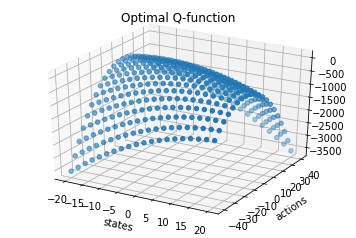

In [47]:
env = lqg1d.LQG1D(initial_state_type='random')
discount = 0.9
horizon = 200

actions = discrete_actions = np.linspace(-40, 40, 20)
states = discrete_states = np.linspace(-20, 20, 20)

#################################################################
# Show the optimal Q-function
#################################################################
def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T

SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

K, cov = env.computeOptimalK(discount), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, discount, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)
ax.set_xlabel('states')
ax.set_ylabel('actions')
plt.title("Optimal Q-function")
plt.show()

In [48]:
#################################################################
# Collect the samples using the behavioural policy
#################################################################
# You should use discrete actions

class naive_policy():
    def __init__(self):
        pass
    def draw_action(state):
        return np.random.choice(discrete_actions)
        
beh_policy = naive_policy
dataset = collect_episodes(env, n_episodes=100,
                                            policy=beh_policy, horizon=horizon)

In [49]:
def quad_features(states,actions):
    #return the matrix of features (a,a*s,a*a+s*s) 
    #caracterizing each pair (state,action)
    
    N = states.shape[0]
    features = np.zeros((N,3))
    features[:,0] = actions 
    features[:,1] = actions * states 
    features[:,2] = actions * actions + states * states
    return features

In [50]:
N_actions = discrete_actions.shape[0]
N_states = discrete_states.shape[0]
N_features = 3

#SA = make_grid(discrete_states, discrete_actions) #already computed before !
#S, A = SA[:, 0], SA[:, 1]
features_grid = quad_features(S,A)

class FQI():
    #implements Fitted Q-iteration

    def __init__(self,lambd=0):
        # lambd : regularization used when updating theta
        
        # quantities used for the update of theta
        self.At = lambd * np.eye(N_features)
        self.bt = np.zeros(N_features)
        
        self.theta = np.zeros(3)
        self.Q = np.zeros((N_states,N_actions))
        
    def update_Q(self, data, gamma):
        # data : new trajectory, gamma : discount factor
        
        # estimate theta
        
        Z = quad_features(data['states'].flatten(),data['actions'].flatten())
        Zt = Z.T
        self.At += Zt.dot(Z)
        
        y = data['rewards'].flatten()
        idx_discrete_next_states = find_closest_discrete_elements(discrete_states,
                                                                  data['next_states'].flatten())
        for t in range(horizon):
            y[t] += gamma * np.max(self.Q[idx_discrete_next_states[t],:])
        self.bt += Zt.dot(y)

        self.theta = np.linalg.inv(self.At).dot(self.bt)
                
        # update Q
                
        Q_values = features_grid.dot(self.theta)
        self.Q = Q_values.reshape((N_states,N_actions))
        
        # truncate Q
        # Vmax = 1000/(1-gamma) #reward bounded by 1000
        # self.Q = np.clip(self.Q,-Vmax,Vmax)
        
    def draw_action(self,state):
        
        # greedy policy with respect to Q
        
        idx_discrete_state = find_closest_discrete_elements(discrete_states,state)[0]
        idx_best_action = np.argmax(self.Q[idx_discrete_state,:]) #greedy policy
        
        return discrete_actions[idx_best_action]

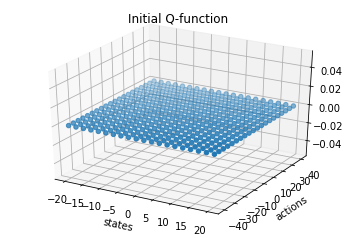

In [51]:
N_episods = len(dataset)
hist_J = np.zeros(N_episods)

fqi = FQI(lambd=0.1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, fqi.Q)
ax.set_xlabel('states')
ax.set_ylabel('actions')
plt.title("Initial Q-function")
plt.show()

for t in range(N_episods): 
    
    data = dataset[t]
    fqi.update_Q(data, discount)
    hist_J[t] = estimate_performance(env, policy=fqi, horizon=50, 
                                     n_episodes=50, gamma=discount)

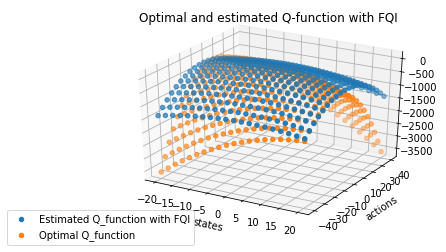

Policy performance: -48.908430564833225


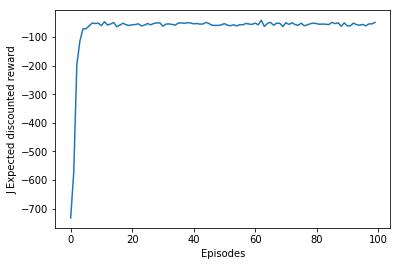

In [52]:
# plot obtained Q-function against the true one

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, fqi.Q, label="Estimated Q_function with FQI")
ax.scatter(S, A, Q_opt, label="Optimal Q_function")
ax.set_xlabel('states')
ax.set_ylabel('actions')
ax.legend(loc='lower center',  bbox_to_anchor=(0.,-0.1))
plt.title("Optimal and estimated Q-function with FQI")
plt.show()

print('Policy performance: {}'.format(hist_J[-1]))

plt.plot(np.arange(len(hist_J)),hist_J)
plt.xlabel("Episodes")
plt.ylabel("J Expected discounted reward")
plt.show()

- I discretized the action space [-40,40] and the state space [-20,20] into 20 bins each for the implementation of FQI.


- For the behavioural policy, I chose uniformly at random the action inside the set of discrete actions in order to explore well the environment.


- Above are shown the optimal and the estimated Q-function at the end of FQI. We do not recover exactly the optimal Q-function, but we clearly improved with respect to the initialization $Q_0 = 0$ ! We can also observe the convergence of the expected discounted reward throughout the iterations.


- However, the performance convergence value seems low compared to the one we get at the end of approximate policy iteration / policy gradient methods (part I). Again, there is certainly paths of improvements for the choice of parameters, but the significant amount of time I spent on this TP (I found very interesting by the way) constrained me not to go further in the analysis.